In [1]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from setting.setting import *

In [2]:
data_dir = "../../dataset/processed/v1/training"
val_data_dir = "../../dataset/processed/v1/validation"
model_dir = "../../models/VGG16"
best_model_filename = 'vgg16_best_model_v1.keras'
os.makedirs(model_dir, exist_ok=True)

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
).map(lambda x, y: (x / 255.0, y))


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_data_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
).map(lambda x, y: (x / 255.0, y))

Found 21945 files belonging to 26 classes.
Found 2465 files belonging to 26 classes.


In [4]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomRotation(0.1),
])

In [5]:

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [6]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))


for layer in base_model.layers:
    layer.trainable = False


model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(26, activation='softmax')
])

In [7]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    mode='min',
    verbose=1
)


checkpoint = ModelCheckpoint(
    os.path.join(model_dir, best_model_filename),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [9]:
final_total_epochs = 1000
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=final_total_epochs,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/100
686/686 [==============================] - ETA: 0s - loss: 1.4596 - accuracy: 0.6145
Epoch 1: val_accuracy improved from -inf to 0.95172, saving model to ../../models/VGG16\vgg16_best_model_v1.keras
686/686 [==============================] - 94s 119ms/step - loss: 1.4596 - accuracy: 0.6145 - val_loss: 0.3718 - val_accuracy: 0.9517
Epoch 2/100
686/686 [==============================] - ETA: 0s - loss: 0.5894 - accuracy: 0.8560
Epoch 2: val_accuracy improved from 0.95172 to 0.97201, saving model to ../../models/VGG16\vgg16_best_model_v1.keras
686/686 [==============================] - 71s 102ms/step - loss: 0.5894 - accuracy: 0.8560 - val_loss: 0.1926 - val_accuracy: 0.9720
Epoch 3/100
686/686 [==============================] - ETA: 0s - loss: 0.3978 - accuracy: 0.9035
Epoch 3: val_accuracy did not improve from 0.97201
686/686 [==============================] - 78s 113ms/step - loss: 0.3978 - accuracy: 0.9035 - val_loss: 0.1427 - val_accuracy: 0.9716
Epoch 4/100
686/686 [====

In [10]:
print(f"Mô hình tốt nhất đã được lưu tại: {os.path.join(model_dir, best_model_filename)}")

Mô hình tốt nhất đã được lưu tại: ../../models/VGG16\vgg16_best_model_v1.keras


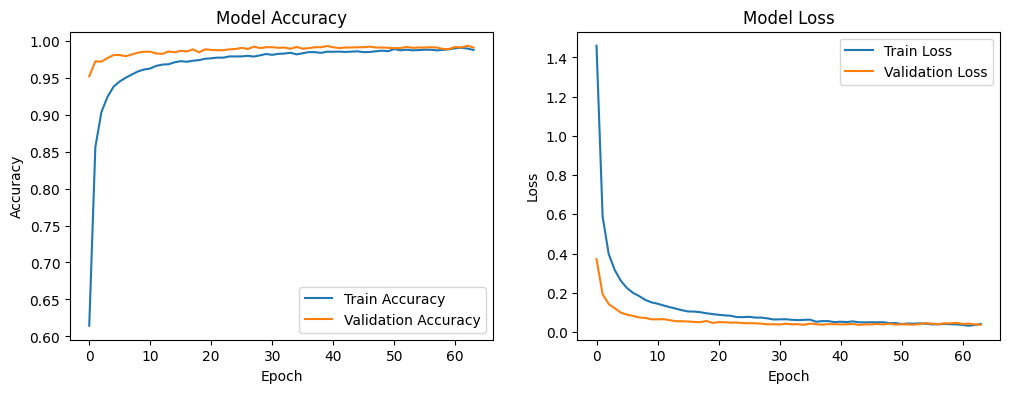

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/1 [==============================] - 0s 431ms/step


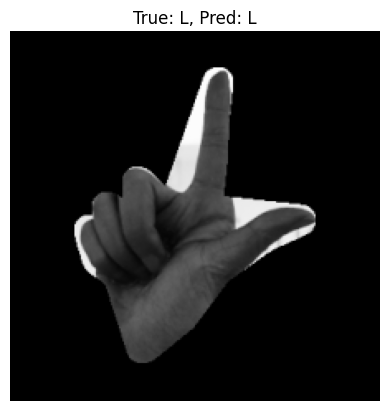

In [12]:
import random
import numpy as np
import string

val_images, val_labels = next(iter(val_ds))
random_index = random.randint(0, BATCH_SIZE - 1)
img = val_images[random_index]
true_label = val_labels[random_index]

pred = model.predict(tf.expand_dims(img, axis=0))
pred_label = string.ascii_uppercase[np.argmax(pred)]
true_label_str = string.ascii_uppercase[np.argmax(true_label)]

plt.imshow(img)
plt.title(f"True: {true_label_str}, Pred: {pred_label}")
plt.axis('off')
plt.show()